# **Description**

# Abstract

Explore Hotel aspects and Predict the rating of each review.

# About this dataset

Hotels play a crucial role in traveling and with the increased access to information new pathways of selecting the best ones emerged.
With this dataset, consisting of 20k reviews crawled from Tripadvisor, you can explore what makes a great hotel and maybe even use this model in your travels!

# How to use

Predict Review Rating
Topic Modeling on Reviews
Explore key aspects that make hotels good or bad
Acknowledgements
If you use this dataset in your research, please credit the authors.

# Citation

Alam, M. H., Ryu, W.-J., Lee, S., 2016. Joint multi-grain topic sentiment: modeling semantic aspects for online reviews. Information Sciences 339, 206–223.
DOI

# License

CC BY NC 4.0

# Splash banner

Photo by Rhema Kallianpur on Unsplash.

# Splash icon

Logo by Tripadvisor.

# Importing Libraries

In [1]:
!pip install bert-for-tf2

     |████████████████████████████████| 41 kB 123 kB/s 
  Created wheel for bert-for-tf2: filename=bert_for_tf2-0.14.9-py3-none-any.whl size=30534 sha256=667ef90c321f2bc20a97979a714727a948e8ffcf658270dace8ccc4f09964345
  Stored in directory: /root/.cache/pip/wheels/47/b6/e5/8c76ec779f54bc5c2f1b57d2200bb9c77616da83873e8acb53
  Created wheel for params-flow: filename=params_flow-0.8.2-py3-none-any.whl size=19473 sha256=48a7e065f6940bcd47e8e89007014c798c32d441d0bd041c01cd2b0d7c23436a
  Stored in directory: /root/.cache/pip/wheels/0e/fc/d2/a44fff33af0f233d7def6e7de413006d57c10e10ad736fe8f5
  Created wheel for py-params: filename=py_params-0.10.2-py3-none-any.whl size=7912 sha256=7f3f342a483db35f759ca81c465b59fbb65e76f67bfdd3256822b7ced0413846
  Stored in directory: /root/.cache/pip/wheels/e1/11/67/33cc51bbee127cb8fb2ba549cd29109b2f22da43ddf9969716
Successfully built bert-for-tf2 params-flow py-params


In [2]:
import numpy as np
import math
import re
import pandas as pd
from bs4 import BeautifulSoup
import random
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers
import bert
import plotly.express as px
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
import spacy

# Analyzing the Data

In [3]:
data = pd.read_csv('../input/trip-advisor-hotel-reviews/tripadvisor_hotel_reviews.csv')
data

,Review,Rating
0,nice hotel expensive parking got good deal sta...,4
1,ok nothing special charge diamond member hilto...,2
2,nice rooms not 4* experience hotel monaco seat...,3
3,"unique, great stay, wonderful time hotel monac...",5
4,"great stay great stay, went seahawk game aweso...",5
...,...,...
20486,"best kept secret 3rd time staying charm, not 5...",5
20487,great location price view hotel great quick pl...,4
20488,"ok just looks nice modern outside, desk staff ...",2
20489,hotel theft ruined vacation hotel opened sept ...,1


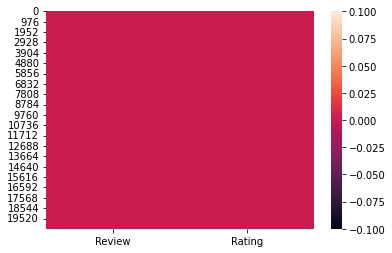

In [4]:
sns.heatmap(data.isnull());

In [5]:
temp = data.describe()
temp.style.background_gradient(cmap='Oranges')

,Rating
count,20491.000000
mean,3.952223
std,1.233030
min,1.000000
25%,3.000000
50%,4.000000
75%,5.000000
max,5.000000


(0.0, 9959.400000000001)

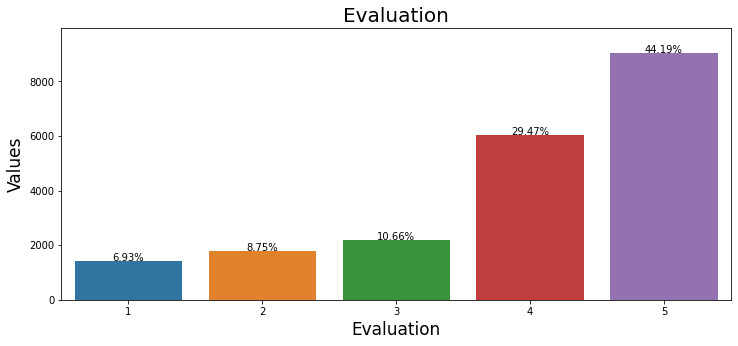

In [6]:
total = len(data)
ax1 = plt.figure(figsize=(12,5))

g = sns.countplot(x='Rating', data=data)
g.set_title("Evaluation", fontsize=20)
g.set_xlabel("Evaluation", fontsize=17)
g.set_ylabel("Values", fontsize=17)
sizes = []
for p in g.patches:
    height = p.get_height()
    sizes.append(height)
    g.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(height/total*100),
            ha="center", fontsize=10) 
g.set_ylim(0, max(sizes) * 1.1)

Now it will depend on the analysis of standards, based on the assessment scores what could be considered a negative assessment.

Let's consider a score less than 2 will be negative, we can consider it to be below 50%.

In [7]:
data['Rating'] = data['Rating'].apply(lambda x: 1 if x >= 2 else 0) 

In [8]:
positive = data[data['Rating'] == 1 ]
negative = data[data['Rating'] == 0]

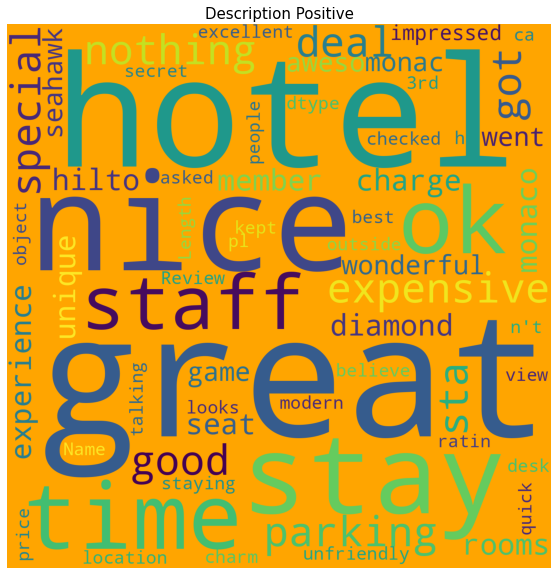

In [9]:
plt.rcParams['figure.figsize'] = (10, 10)
plt.style.use('fast')

wc = WordCloud(background_color = 'orange', width = 1500, height = 1500).generate(str(positive['Review']))
plt.title('Description Positive', fontsize = 15)

plt.imshow(wc)
plt.axis('off')
plt.show()

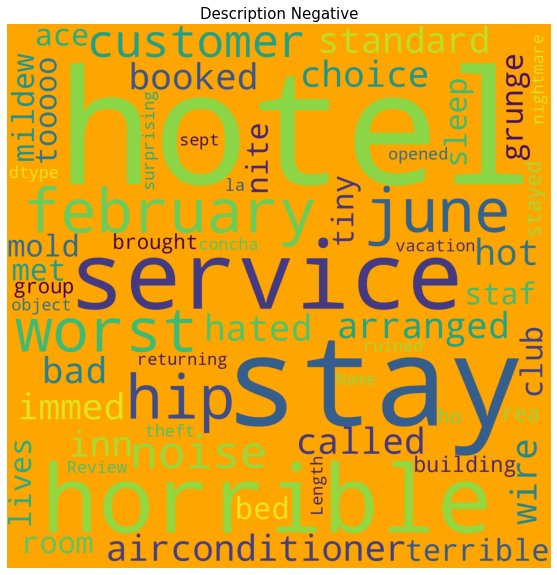

In [10]:
plt.rcParams['figure.figsize'] = (10, 10)
plt.style.use('fast')

wc = WordCloud(background_color = 'orange', width = 1500, height = 1500).generate(str(negative['Review']))
plt.title('Description Negative', fontsize = 15)

plt.imshow(wc)
plt.axis('off')
plt.show()

In [11]:
data.head()

,Review,Rating
0,nice hotel expensive parking got good deal sta...,1
1,ok nothing special charge diamond member hilto...,1
2,nice rooms not 4* experience hotel monaco seat...,1
3,"unique, great stay, wonderful time hotel monac...",1
4,"great stay great stay, went seahawk game aweso...",1


# Processing

In [12]:
def clean_t(t):
  t = BeautifulSoup(t, 'lxml').get_text()
  t = re.sub(r"@[A-Za-z0-9]+", ' ', t)
  t = re.sub(r"https?://[A-Za-z0-9./]+", ' ', t)
  t = re.sub(r"[^a-zA-Z.!?]", ' ', t)
  t = re.sub(r" +", ' ', t)
  return t

In [13]:
test = '99 ' + data.Review[0]
test

'99 nice hotel expensive parking got good deal stay hotel anniversary, arrived late evening took advice previous reviews did valet parking, check quick easy, little disappointed non-existent view room room clean nice size, bed comfortable woke stiff neck high pillows, not soundproof like heard music room night morning loud bangs doors opening closing hear people talking hallway, maybe just noisy neighbors, aveda bath products nice, did not goldfish stay nice touch taken advantage staying longer, location great walking distance shopping, overall nice experience having pay 40 parking night,  '

In [14]:
result = clean_t(test)
result

' nice hotel expensive parking got good deal stay hotel anniversary arrived late evening took advice previous reviews did valet parking check quick easy little disappointed non existent view room room clean nice size bed comfortable woke stiff neck high pillows not soundproof like heard music room night morning loud bangs doors opening closing hear people talking hallway maybe just noisy neighbors aveda bath products nice did not goldfish stay nice touch taken advantage staying longer location great walking distance shopping overall nice experience having pay parking night '

In [15]:
data_clean = [clean_t(t) for t in data.Review]

In [16]:
data_clean[0:4]

['nice hotel expensive parking got good deal stay hotel anniversary arrived late evening took advice previous reviews did valet parking check quick easy little disappointed non existent view room room clean nice size bed comfortable woke stiff neck high pillows not soundproof like heard music room night morning loud bangs doors opening closing hear people talking hallway maybe just noisy neighbors aveda bath products nice did not goldfish stay nice touch taken advantage staying longer location great walking distance shopping overall nice experience having pay parking night ',
 'ok nothing special charge diamond member hilton decided chain shot th anniversary seattle start booked suite paid extra website description not suite bedroom bathroom standard hotel room took printed reservation desk showed said things like tv couch ect desk clerk told oh mixed suites description kimpton website sorry free breakfast got kidding embassy suits sitting room bathroom bedroom unlike kimpton calls sui

In [17]:
FullTokenizer = bert.bert_tokenization.FullTokenizer
bert_layer = hub.KerasLayer('https://tfhub.dev/tensorflow/bert_en_uncased_L-24_H-1024_A-16/1', trainable=False)
vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = FullTokenizer(vocab_file, do_lower_case)

2021-11-29 16:45:32.045773: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-29 16:45:32.047046: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-29 16:45:32.047780: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-29 16:45:32.048656: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [18]:
vocab_file

b'/tmp/tfhub_modules/88ac13afec2955fd14396e4582c251841b67429a/assets/vocab.txt'

In [19]:
len(tokenizer.vocab)

30522

In [20]:
tokenizer.tokenize('My dog likes strawberries.')

['my', 'dog', 'likes', 'straw', '##berries', '.']

In [21]:
tokenizer.convert_tokens_to_ids(tokenizer.tokenize('My dog likes strawberries.'))

[2026, 3899, 7777, 13137, 20968, 1012]

In [22]:
def encode_sentence(sent):
  return tokenizer.convert_tokens_to_ids(tokenizer.tokenize(sent))

In [23]:
encode_sentence('my dog likes strawberries')

[2026, 3899, 7777, 13137, 20968]

In [24]:
data_inputs = [encode_sentence(sentence) for sentence in data_clean]

In [25]:
data_inputs[1]

[7929,
 2498,
 2569,
 3715,
 6323,
 2266,
 15481,
 2787,
 4677,
 2915,
 16215,
 5315,
 5862,
 2707,
 17414,
 7621,
 3825,
 4469,
 4037,
 6412,
 2025,
 7621,
 5010,
 5723,
 3115,
 3309,
 2282,
 2165,
 6267,
 11079,
 4624,
 3662,
 2056,
 2477,
 2066,
 2694,
 6411,
 14925,
 2102,
 4624,
 7805,
 2409,
 2821,
 3816,
 19796,
 6412,
 5035,
 15857,
 4037,
 3374,
 2489,
 6350,
 2288,
 12489,
 8408,
 11072,
 3564,
 2282,
 5723,
 5010,
 4406,
 5035,
 15857,
 4455,
 7621,
 2154,
 2994,
 3749,
 6149,
 6270,
 6475,
 4604,
 5035,
 15857,
 6871,
 4113,
 4037,
 10373,
 4851,
 4945,
 3073,
 7621,
 17099,
 4037,
 11079,
 6412,
 19851,
 2524,
 6100,
 11079,
 6140,
 5833,
 4037,
 4624,
 3208,
 4611,
 2106,
 2025,
 7514,
 5576,
 4604,
 10373,
 4440,
 4113,
 5002,
 2106,
 2025,
 3582,
 10373,
 5653,
 3984,
 2425,
 4986,
 4113,
 1012,
 1996,
 3095,
 15844,
 24436,
 2025,
 14044,
 2356,
 4624,
 2204,
 6350,
 7516,
 5101,
 7415,
 2409,
 2053,
 9275,
 20277,
 2190,
 6350,
 7516,
 5862,
 3796,
 2185,
 14057,
 330

# Database creation

In [26]:
data_labels = data.iloc[:,1].values

In [27]:
data_labels

array([1, 1, 1, ..., 1, 0, 1])

In [28]:
data_with_len = [[sent, data_labels[i], len(sent)]
                 for i, sent in enumerate(data_inputs)]

In [29]:
data_with_len[0:2]

[[[3835,
   3309,
   6450,
   5581,
   2288,
   2204,
   3066,
   2994,
   3309,
   5315,
   3369,
   2397,
   3944,
   2165,
   6040,
   3025,
   4391,
   2106,
   27238,
   5581,
   4638,
   4248,
   3733,
   2210,
   9364,
   2512,
   25953,
   3193,
   2282,
   2282,
   4550,
   3835,
   2946,
   2793,
   6625,
   8271,
   10551,
   3300,
   2152,
   17860,
   2025,
   2614,
   18907,
   2066,
   2657,
   2189,
   2282,
   2305,
   2851,
   5189,
   28490,
   4303,
   3098,
   5494,
   2963,
   2111,
   3331,
   6797,
   2672,
   2074,
   20810,
   10638,
   13642,
   2850,
   7198,
   3688,
   3835,
   2106,
   2025,
   2751,
   7529,
   2994,
   3835,
   3543,
   2579,
   5056,
   6595,
   2936,
   3295,
   2307,
   3788,
   3292,
   6023,
   3452,
   3835,
   3325,
   2383,
   3477,
   5581,
   2305],
  1,
  90],
 [[7929,
   2498,
   2569,
   3715,
   6323,
   2266,
   15481,
   2787,
   4677,
   2915,
   16215,
   5315,
   5862,
   2707,
   17414,
   7621,
   3825,
   4469,
   

In [30]:
random.shuffle(data_with_len)
data_with_len.sort(key=lambda x: x[2])
sorted_all = [(sent_lab[0], sent_lab[1])
              for sent_lab in data_with_len if sent_lab[2] > 7]

In [31]:
sorted_all[3000:3005]

[([2498,
   2569,
   15003,
   2157,
   3309,
   4037,
   2025,
   3309,
   6595,
   10908,
   5667,
   2275,
   2982,
   2307,
   2811,
   22861,
   2232,
   2363,
   2627,
   2908,
   10401,
   1050,
   1056,
   2215,
   2994,
   3976,
   13003,
   4276,
   2431,
   3976,
   2672,
   3976,
   2215,
   2994,
   7601,
   2630,
   9154,
   9686,
   4842,
   16076,
   2173,
   2215],
  1),
 ([5791,
   16755,
   17414,
   3309,
   3978,
   4391,
   3191,
   4440,
   4748,
   15088,
   3771,
   2025,
   9364,
   2165,
   12954,
   6396,
   2420,
   2359,
   2191,
   2569,
   2204,
   3643,
   2307,
   3295,
   2939,
   9530,
   3401,
   4313,
   3351,
   8403,
   1058,
   14044,
   2709,
   13431,
   1012,
   1045,
   2253,
   2257,
   9471,
   3319,
   2051,
   3374],
  1),
 ([3835,
   2994,
   6425,
   2074,
   2513,
   2305,
   2994,
   6425,
   2245,
   3835,
   3309,
   2282,
   3760,
   2946,
   2053,
   3760,
   3115,
   2282,
   1059,
   1012,
   2326,
   6581,
   4624,
   9530,
  

In [32]:
all_dataset = tf.data.Dataset.from_generator(lambda: sorted_all,
                                             output_types = (tf.int32, tf.int32))

In [33]:
next(iter(all_dataset))

2021-11-29 16:46:53.013675: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


(<tf.Tensor: shape=(8,), dtype=int32, numpy=array([3835, 3309, 3193, 2117, 2282, 2282, 2187, 5216], dtype=int32)>,
 <tf.Tensor: shape=(), dtype=int32, numpy=1>)

In [34]:
BATCH_SIZE = 32
all_batched = all_dataset.padded_batch(BATCH_SIZE, padded_shapes=((None, ), ()))

In [35]:
next(iter(all_batched))

(<tf.Tensor: shape=(32, 12), dtype=int32, numpy=
 array([[ 3835,  3309,  3193,  2117,  2282,  2282,  2187,  5216,     0,
             0,     0,     0],
        [ 3314,  1050,  1056,  2360,  2732,  2326,  2307,  4770,  3347,
             0,     0,     0],
        [11519,  2173,  2994,  3976,  2793,  2157,  5723,  4098,  4084,
             0,     0,     0],
        [ 5580,  4370,  2307,  3325,  2994,  2051,  4084, 14271, 10356,
             0,     0,     0],
        [ 2193,  3309,  2193,  5464,  3819,  2126,  2190,  6350,  2088,
             0,     0,     0],
        [ 2204,  3295,  3835,  2485,  6023,  2586,  2675,  2502,  4606,
          2779,     0,     0],
        [ 3835,  5976,  3835,  2173,  2994,  2074, 24115,  3773,  3000,
          2204,     0,     0],
        [ 2307,  3309,  3866,  3309,  3295,  3819,  3095,  2307,  5791,
          2994,     0,     0],
        [ 7729,  2293,  2686, 23775, 12726, 18772,  9467,  2307,  6891,
          7729,     0,     0],
        [ 2204,  3601,  

In [36]:
len(sorted_all)

20490

In [37]:
NB_BATCHES = len(sorted_all) // BATCH_SIZE
NB_BATCHES

640

In [38]:
NB_BATCHES_TEST = NB_BATCHES // 10
NB_BATCHES_TEST

64

In [39]:
all_batched.shuffle(NB_BATCHES)
test_dataset = all_batched.take(NB_BATCHES_TEST)
train_dataset = all_batched.skip(NB_BATCHES_TEST)

In [40]:
next(iter(test_dataset))

(<tf.Tensor: shape=(32, 12), dtype=int32, numpy=
 array([[ 3835,  3309,  3193,  2117,  2282,  2282,  2187,  5216,     0,
             0,     0,     0],
        [ 3314,  1050,  1056,  2360,  2732,  2326,  2307,  4770,  3347,
             0,     0,     0],
        [11519,  2173,  2994,  3976,  2793,  2157,  5723,  4098,  4084,
             0,     0,     0],
        [ 5580,  4370,  2307,  3325,  2994,  2051,  4084, 14271, 10356,
             0,     0,     0],
        [ 2193,  3309,  2193,  5464,  3819,  2126,  2190,  6350,  2088,
             0,     0,     0],
        [ 2204,  3295,  3835,  2485,  6023,  2586,  2675,  2502,  4606,
          2779,     0,     0],
        [ 3835,  5976,  3835,  2173,  2994,  2074, 24115,  3773,  3000,
          2204,     0,     0],
        [ 2307,  3309,  3866,  3309,  3295,  3819,  3095,  2307,  5791,
          2994,     0,     0],
        [ 7729,  2293,  2686, 23775, 12726, 18772,  9467,  2307,  6891,
          7729,     0,     0],
        [ 2204,  3601,  

In [41]:
next(iter(train_dataset))

(<tf.Tensor: shape=(32, 36), dtype=int32, numpy=
 array([[ 2204,  3295,  3937, ...,  2734,  2460,  2994],
        [ 8235,  3309,  3811, ...,  1056,  3524,  2994],
        [ 9202, 22452,  3309, ...,  1996,  5101, 25135],
        ...,
        [ 3835,  2181,  7091, ...,  2015,  7144,  2015],
        [ 3309, 11463,  2050, ..., 14044,  5791,  2994],
        [ 2994,  2307,  3309, ..., 11848,  2854,  2095]], dtype=int32)>,
 <tf.Tensor: shape=(32,), dtype=int32, numpy=
 array([1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32)>)

# Model building

In [42]:
class DCNN(tf.keras.Model):

  def __init__(self,
               vocab_size,
               emb_dim=128,
               nb_filters = 50,
               FFN_units=512,
               nb_classes=2,
               dropout_rate=0.1,
               training=False,
               name="dcnn"):
    super(DCNN, self).__init__(name=name)

    self.embedding = layers.Embedding(vocab_size, emb_dim)

    self.bigram = layers.Conv1D(filters = nb_filters,
                                kernel_size = 2,
                                padding='valid',
                                activation='relu')
    self.trigram = layers.Conv1D(filters = nb_filters,
                                kernel_size = 3,
                                padding='valid',
                                activation='relu')
    self.fourgram = layers.Conv1D(filters = nb_filters,
                                kernel_size = 4,
                                padding='valid',
                                activation='relu')
    
    self.pool = layers.GlobalMaxPool1D()

    self.dense_1 = layers.Dense(units = FFN_units, activation='relu')
    self.dropout = layers.Dropout(rate=dropout_rate)
    if nb_classes == 2:
      self.last_dense = layers.Dense(units=1, activation='sigmoid')
    else:
      self.last_dense = layers.Dense(units=nb_classes, activation='softmax')

  def call(self, inputs, training):
    x = self.embedding(inputs)
    x_1 = self.bigram(x)
    x_1 = self.pool(x_1)
    x_2 = self.trigram(x)
    x_2 = self.pool(x_2)
    x_3 = self.fourgram(x)
    x_3 = self.pool(x_3)

    merged = tf.concat([x_1, x_2, x_3], axis = -1)
    merged = self.dense_1(merged)
    merged = self.dropout(merged, training)
    output = self.last_dense(merged)

    return output

# Training

In [43]:
VOCAB_SIZE = len(tokenizer.vocab)
EMB_DIM = 200
NB_FILTERS = 100
FFN_UNITS = 256
NB_CLASSES = 2
DROPOUT_RATE = 0.2
NB_EPOCHS = 12

In [44]:
Dcnn = DCNN(vocab_size=VOCAB_SIZE,
            emb_dim=EMB_DIM,
            nb_filters = NB_FILTERS,
            FFN_units = FFN_UNITS,
            nb_classes = NB_CLASSES,
            dropout_rate = DROPOUT_RATE)

In [45]:
if NB_CLASSES == 2:
  Dcnn.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
else:
  Dcnn.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['sparse_categorical_accuracy'])

In [46]:
history = Dcnn.fit(train_dataset,
                   epochs=NB_EPOCHS)

Epoch 1/12


2021-11-29 16:46:57.588834: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


577/577 [==============================] - 40s 57ms/step - loss: 0.1529 - accuracy: 0.9414
Epoch 2/12
577/577 [==============================] - 7s 12ms/step - loss: 0.0605 - accuracy: 0.9747
Epoch 3/12
577/577 [==============================] - 7s 12ms/step - loss: 0.0157 - accuracy: 0.9949
Epoch 4/12
577/577 [==============================] - 7s 12ms/step - loss: 0.0094 - accuracy: 0.9969
Epoch 5/12
577/577 [==============================] - 7s 11ms/step - loss: 0.0019 - accuracy: 0.9994
Epoch 6/12
577/577 [==============================] - 7s 12ms/step - loss: 5.8851e-04 - accuracy: 0.9998
Epoch 7/12
577/577 [==============================] - 8s 13ms/step - loss: 0.0024 - accuracy: 0.9992
Epoch 8/12
577/577 [==============================] - 7s 11ms/step - loss: 0.0036 - accuracy: 0.9987
Epoch 9/12
577/577 [==============================] - 7s 12ms/step - loss: 0.0085 - accuracy: 0.9973
Epoch 10/12
577/577 [==============================] - 7s 12ms/step - loss: 0.0056 - accuracy: 0.

# Evaluation

In [47]:
history.history.keys()

dict_keys(['loss', 'accuracy'])

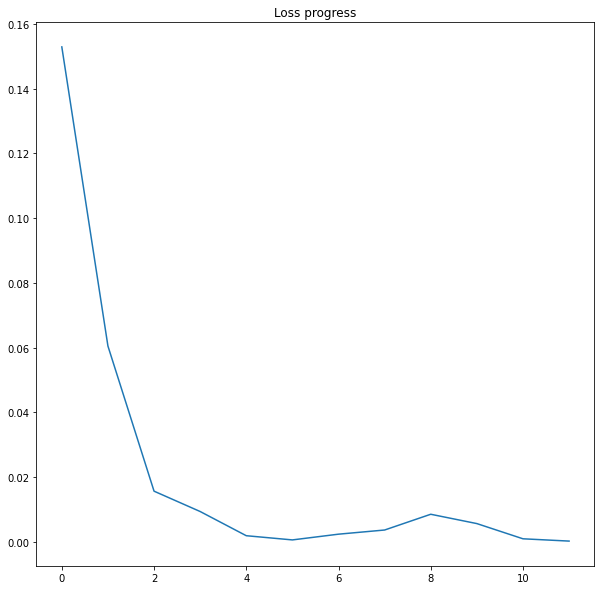

In [48]:
plt.plot(history.history['loss'])
plt.title('Loss progress');

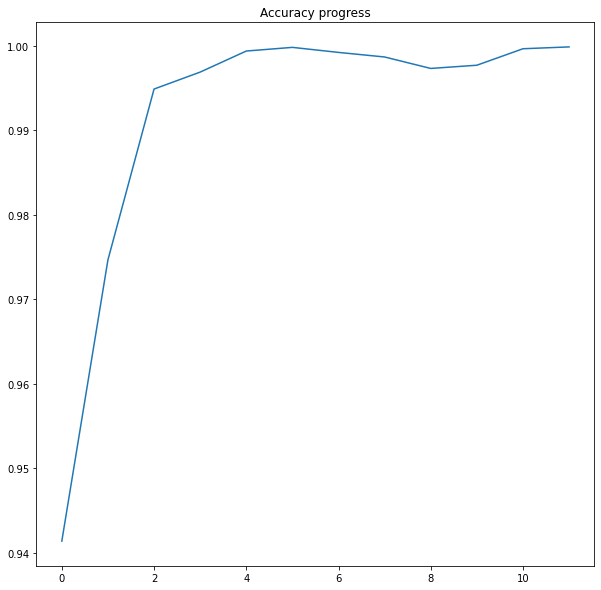

In [49]:
plt.plot(history.history['accuracy'])
plt.title('Accuracy progress');

In [50]:
results = Dcnn.evaluate(test_dataset)
print(results)

64/64 [==============================] - 1s 13ms/step - loss: 0.2420 - accuracy: 0.9653
[0.2419648915529251, 0.96533203125]


In [51]:
def get_prediction(sentence):
  tokens = encode_sentence(sentence)
  inputs = tf.expand_dims(tokens, 0)
  output = Dcnn(inputs, training=False)
  sentiment = math.floor(output*2)
  if sentiment == 0:
    print('negative')
  elif sentiment == 1:
    print('positive')

In [52]:
get_prediction('This movie was pretty interesting')

positive


In [53]:
get_prediction("I'd rather not do that again")

negative


In [54]:
get_prediction("I don't like you")

negative


# **If you find this notebook useful, support with an upvote** 👍